### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from statistics import mean
import tensorflow as tf

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_Landsat8.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_cl…

### Generating chips

In [4]:
# normalize the image and generate chips
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i, :, :].min()
    bandMax = arrFeatures[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures_fuzzy[i, j, k] = (arrFeatures[i, j, k]-bandMin)/bandRange

# create chips using pyrsgis
features_chips = imageChipsFromArray(arrFeatures_fuzzy, x_size=7, y_size=7)

### Loading the training dataset (manual)

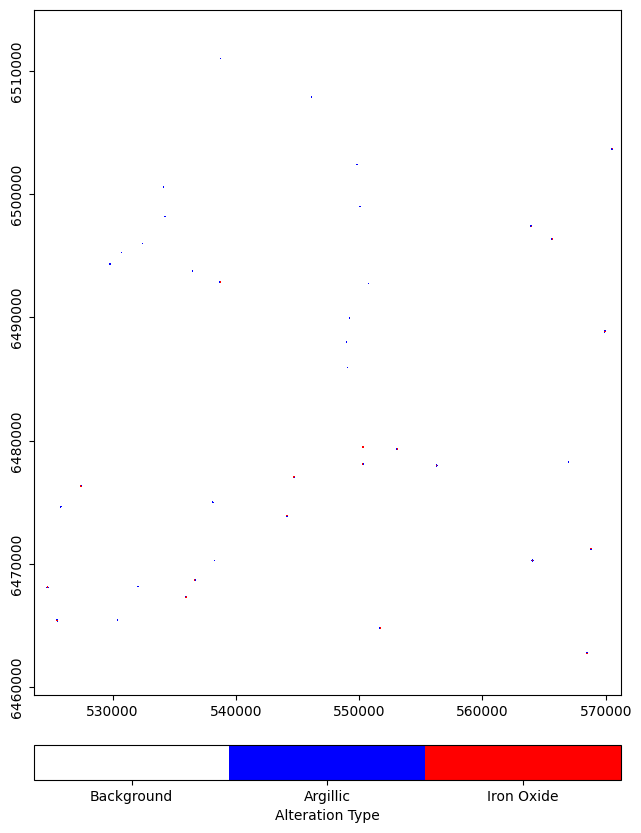

In [5]:
positiveLabel_file = './BrokenHill_Landsat8_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0

### Splitting features and labels into training and test datasets

In [7]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 1.1041 - accuracy: 0.3429 - val_loss: 1.0806 - val_accuracy: 0.3267
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0657 - accuracy: 0.4152 - val_loss: 1.0043 - val_accuracy: 0.6756
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9813 - accuracy: 0.5314 - val_loss: 0.8837 - val_accuracy: 0.6289
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8698 - accuracy: 0.5971 - val_loss: 0.7293 - val_accuracy: 0.7556
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8098 - accuracy: 0.6371 - val_loss: 0.7302 - val_accuracy: 0.7289
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.7862 - accuracy: 0.6743 - val_loss: 0.6718 - val_accuracy: 0.7311
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7300 - accuracy: 0.6971 - val_loss: 0.5985 - val_accuracy: 0.7867
Epoch 8/100
3

Epoch 59/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1990 - accuracy: 0.9276 - val_loss: 0.1223 - val_accuracy: 0.9578
Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1559 - accuracy: 0.9457 - val_loss: 0.1068 - val_accuracy: 0.9667
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1533 - accuracy: 0.9476 - val_loss: 0.1214 - val_accuracy: 0.9556
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1440 - accuracy: 0.9524 - val_loss: 0.1539 - val_accuracy: 0.9467
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1589 - accuracy: 0.9467 - val_loss: 0.2232 - val_accuracy: 0.9089
Epoch 64/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1614 - accuracy: 0.9362 - val_loss: 0.1091 - val_accuracy: 0.9622
Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1387 - accuracy: 0.9505 - val_loss: 0.1364 - val_accuracy: 0.9489
Epoch 

Epoch 67/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1464 - accuracy: 0.9533 - val_loss: 0.1456 - val_accuracy: 0.9578
Epoch 68/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1673 - accuracy: 0.9381 - val_loss: 0.1217 - val_accuracy: 0.9644
Epoch 69/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1547 - accuracy: 0.9429 - val_loss: 0.0813 - val_accuracy: 0.9867
Epoch 70/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1452 - accuracy: 0.9495 - val_loss: 0.1398 - val_accuracy: 0.9467
Epoch 71/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1495 - accuracy: 0.9429 - val_loss: 0.0961 - val_accuracy: 0.9756
Epoch 72/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1410 - accuracy: 0.9524 - val_loss: 0.0880 - val_accuracy: 0.9800
Epoch 73/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9410 - val_loss: 0.1023 - val_accuracy: 0.9756
Epoch 

Epoch 75/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1002 - accuracy: 0.9610 - val_loss: 0.1613 - val_accuracy: 0.9533
Epoch 76/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1618 - accuracy: 0.9390 - val_loss: 0.1871 - val_accuracy: 0.9489
Epoch 77/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1425 - accuracy: 0.9419 - val_loss: 0.1518 - val_accuracy: 0.9356
Epoch 78/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9676 - val_loss: 0.1567 - val_accuracy: 0.9444
Epoch 79/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1140 - accuracy: 0.9562 - val_loss: 0.1484 - val_accuracy: 0.9356
Epoch 80/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1236 - accuracy: 0.9533 - val_loss: 0.1818 - val_accuracy: 0.9444
Epoch 81/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9590 - val_loss: 0.1255 - val_accuracy: 0.9622
Epoch 

Epoch 83/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1638 - accuracy: 0.9390 - val_loss: 0.1203 - val_accuracy: 0.9556
Epoch 84/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9457 - val_loss: 0.1771 - val_accuracy: 0.9156
Epoch 85/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1463 - accuracy: 0.9467 - val_loss: 0.1032 - val_accuracy: 0.9689
Epoch 86/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1558 - accuracy: 0.9410 - val_loss: 0.1385 - val_accuracy: 0.9378
Epoch 87/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1362 - accuracy: 0.9495 - val_loss: 0.0998 - val_accuracy: 0.9711
Epoch 88/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1855 - accuracy: 0.9333 - val_loss: 0.1201 - val_accuracy: 0.9489
Epoch 89/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.9514 - val_loss: 0.1060 - val_accuracy: 0.9689
Epoch 

Epoch 91/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1383 - accuracy: 0.9524 - val_loss: 0.1729 - val_accuracy: 0.9333
Epoch 92/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9419 - val_loss: 0.1666 - val_accuracy: 0.9378
Epoch 93/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1429 - accuracy: 0.9514 - val_loss: 0.0951 - val_accuracy: 0.9667
Epoch 94/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1425 - accuracy: 0.9533 - val_loss: 0.0913 - val_accuracy: 0.9689
Epoch 95/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9514 - val_loss: 0.0853 - val_accuracy: 0.9756
Epoch 96/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.9619 - val_loss: 0.0888 - val_accuracy: 0.9711
Epoch 97/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9419 - val_loss: 0.1757 - val_accuracy: 0.9356
Epoch 

Epoch 99/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1226 - accuracy: 0.9581 - val_loss: 0.2393 - val_accuracy: 0.9111
Epoch 100/100
15/15 [==============================] - 0s 1ms/step
Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 1.1065 - accuracy: 0.3790 - val_loss: 1.0667 - val_accuracy: 0.6400
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0612 - accuracy: 0.4219 - val_loss: 0.9917 - val_accuracy: 0.5800
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9538 - accuracy: 0.5457 - val_loss: 0.8121 - val_accuracy: 0.7444
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8593 - accuracy: 0.6267 - val_loss: 0.7348 - val_accuracy: 0.7200
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8146 - accuracy: 0.6324 - val_loss: 0.6950 - val_accuracy: 0.7356
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7794 - accu

15/15 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - 1s 9ms/step - loss: 1.1149 - accuracy: 0.3514 - val_loss: 1.0771 - val_accuracy: 0.3422
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0595 - accuracy: 0.4305 - val_loss: 1.0056 - val_accuracy: 0.5378
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.9468 - accuracy: 0.5648 - val_loss: 0.8158 - val_accuracy: 0.6978
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 0.8289 - accuracy: 0.6352 - val_loss: 0.7524 - val_accuracy: 0.6200
Epoch 5/100
33/33 [==============================] - 0s 5ms/step - loss: 0.8081 - accuracy: 0.6105 - val_loss: 0.7308 - val_accuracy: 0.6889
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.7956 - accuracy: 0.6333 - val_loss: 0.7825 - val_accuracy: 0.6333
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 0.7295 - accuracy: 0.7124 - 

Epoch 57/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1427 - accuracy: 0.9467 - val_loss: 0.1623 - val_accuracy: 0.9422
Epoch 58/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1805 - accuracy: 0.9381 - val_loss: 0.2192 - val_accuracy: 0.9156
Epoch 59/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1851 - accuracy: 0.9371 - val_loss: 0.1622 - val_accuracy: 0.9356
Epoch 60/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1581 - accuracy: 0.9438 - val_loss: 0.1774 - val_accuracy: 0.9422
Epoch 61/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1920 - accuracy: 0.9305 - val_loss: 0.2152 - val_accuracy: 0.8978
Epoch 62/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1500 - accuracy: 0.9543 - val_loss: 0.1653 - val_accuracy: 0.9400
Epoch 63/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1539 - accuracy: 0.9448 - val_loss: 0.1513 - val_accuracy: 0.9444
Epoch 

Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1755 - accuracy: 0.9381 - val_loss: 0.1871 - val_accuracy: 0.9311
Epoch 66/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9343 - val_loss: 0.1432 - val_accuracy: 0.9556
Epoch 67/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1176 - accuracy: 0.9638 - val_loss: 0.1308 - val_accuracy: 0.9600
Epoch 68/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1350 - accuracy: 0.9467 - val_loss: 0.1275 - val_accuracy: 0.9533
Epoch 69/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1140 - accuracy: 0.9638 - val_loss: 0.1374 - val_accuracy: 0.9556
Epoch 70/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9619 - val_loss: 0.1655 - val_accuracy: 0.9400
Epoch 71/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1279 - accuracy: 0.9562 - val_loss: 0.1612 - val_accuracy: 0.9333
Epoch 

Epoch 73/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1709 - accuracy: 0.9448 - val_loss: 0.1626 - val_accuracy: 0.9467
Epoch 74/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1998 - accuracy: 0.9257 - val_loss: 0.2339 - val_accuracy: 0.9067
Epoch 75/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1931 - accuracy: 0.9305 - val_loss: 0.1194 - val_accuracy: 0.9578
Epoch 76/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1455 - accuracy: 0.9524 - val_loss: 0.1203 - val_accuracy: 0.9533
Epoch 77/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1441 - accuracy: 0.9486 - val_loss: 0.1024 - val_accuracy: 0.9644
Epoch 78/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1523 - accuracy: 0.9495 - val_loss: 0.1257 - val_accuracy: 0.9556
Epoch 79/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9533 - val_loss: 0.1263 - val_accuracy: 0.9533
Epoch 

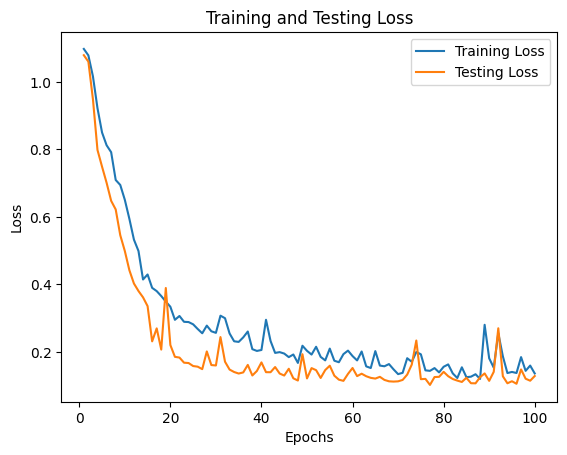

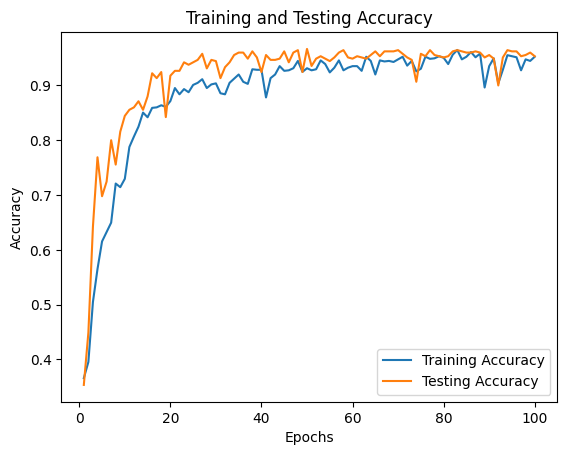

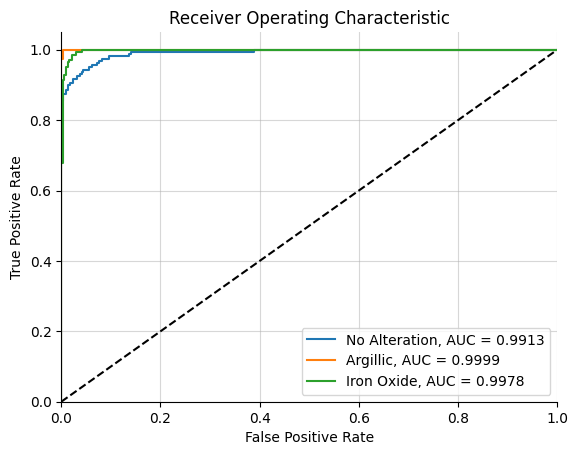

ROC AUC score: 0.9963303054159492


In [8]:
def roc_auc(model, test_x, test_y, n_classes):
    roc_auc = []
    test_z = model.predict(test_x)
    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))
    
    return roc_auc

# plot any graph relating to any model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()
    
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Iron Oxide', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))

    for j in range(cv):
        train_x, train_y, test_x, test_y = train_test_split(features, labels)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Iron Oxide']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

91947/91947 [==============================] - 99s 1ms/step


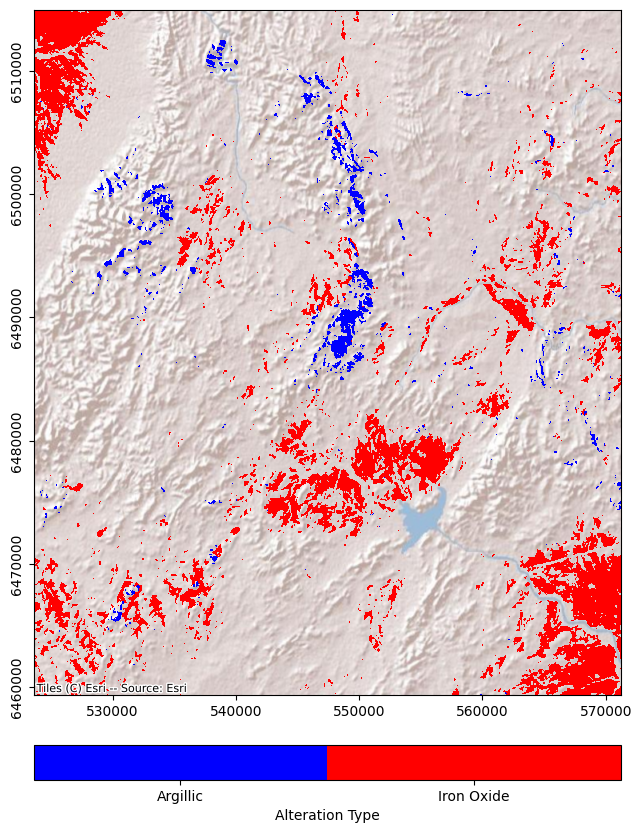

In [9]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
arrPred = arrPred.astype(float)
arrPred_fuzzy = np.zeros(arrPred.shape)

for i in range(arrPred.shape[0]):
    bandMin = arrPred[i, :, :].min()
    bandMax = arrPred[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[1]):
        for k in range(arrPred.shape[2]):
            arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# generate image chips from the array
pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

# predict and export the probability raster
pred = best_model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat8_Manual_CNN_AlterationMap_ks_7.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

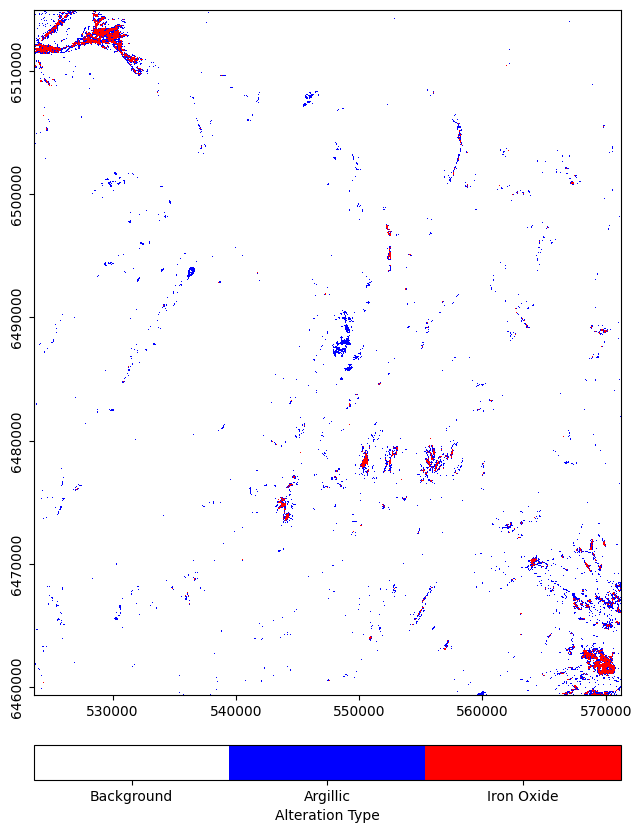

In [10]:
positiveLabel_file = './BrokenHill_Landsat8_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [11]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0

### Splitting features and labels into training and test datasets

In [12]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

Epoch 1/50
2118/2118 [==============================] - 37s 17ms/step - loss: 0.5247 - accuracy: 0.7796 - val_loss: 0.3187 - val_accuracy: 0.8704
Epoch 2/50
2118/2118 [==============================] - 37s 17ms/step - loss: 0.3352 - accuracy: 0.8746 - val_loss: 0.2077 - val_accuracy: 0.9251
Epoch 3/50
2118/2118 [==============================] - 37s 17ms/step - loss: 0.2766 - accuracy: 0.9005 - val_loss: 0.2075 - val_accuracy: 0.9222
Epoch 4/50
2118/2118 [==============================] - 37s 18ms/step - loss: 0.2322 - accuracy: 0.9176 - val_loss: 0.1415 - val_accuracy: 0.9487
Epoch 5/50
2118/2118 [==============================] - 37s 17ms/step - loss: 0.2079 - accuracy: 0.9282 - val_loss: 0.1741 - val_accuracy: 0.9360
Epoch 6/50
2118/2118 [==============================] - 37s 18ms/step - loss: 0.1978 - accuracy: 0.9316 - val_loss: 0.1183 - val_accuracy: 0.9587
Epoch 7/50
2118/2118 [==============================] - 36s 17ms/step - loss: 0.1838 - accuracy: 0.9366 - val_loss: 0.1826 -

908/908 [==============================] - 5s 6ms/step
Epoch 1/50
2118/2118 [==============================] - 39s 18ms/step - loss: 0.5797 - accuracy: 0.7493 - val_loss: 0.2797 - val_accuracy: 0.8930
Epoch 2/50
2118/2118 [==============================] - 38s 18ms/step - loss: 0.3361 - accuracy: 0.8771 - val_loss: 0.2072 - val_accuracy: 0.9257
Epoch 3/50
2118/2118 [==============================] - 39s 18ms/step - loss: 0.2671 - accuracy: 0.9058 - val_loss: 0.2226 - val_accuracy: 0.9146
Epoch 4/50
2118/2118 [==============================] - 38s 18ms/step - loss: 0.2353 - accuracy: 0.9190 - val_loss: 0.1548 - val_accuracy: 0.9438
Epoch 5/50
2118/2118 [==============================] - 37s 18ms/step - loss: 0.2099 - accuracy: 0.9286 - val_loss: 0.1183 - val_accuracy: 0.9622
Epoch 6/50
2118/2118 [==============================] - 41s 19ms/step - loss: 0.2009 - accuracy: 0.9335 - val_loss: 0.1154 - val_accuracy: 0.9626
Epoch 7/50
2118/2118 [==============================] - 41s 19ms/step

908/908 [==============================] - 6s 7ms/step
Epoch 1/50
2118/2118 [==============================] - 46s 21ms/step - loss: 0.4994 - accuracy: 0.7914 - val_loss: 0.3239 - val_accuracy: 0.8710
Epoch 2/50
2118/2118 [==============================] - 47s 22ms/step - loss: 0.3211 - accuracy: 0.8808 - val_loss: 0.1943 - val_accuracy: 0.9272
Epoch 3/50
2118/2118 [==============================] - 45s 21ms/step - loss: 0.2711 - accuracy: 0.9026 - val_loss: 0.1623 - val_accuracy: 0.9416
Epoch 4/50
2118/2118 [==============================] - 46s 22ms/step - loss: 0.2337 - accuracy: 0.9191 - val_loss: 0.2938 - val_accuracy: 0.8876
Epoch 5/50
2118/2118 [==============================] - 46s 22ms/step - loss: 0.2144 - accuracy: 0.9263 - val_loss: 0.1555 - val_accuracy: 0.9428
Epoch 6/50
2118/2118 [==============================] - 45s 21ms/step - loss: 0.1917 - accuracy: 0.9347 - val_loss: 0.1926 - val_accuracy: 0.9437
Epoch 7/50
2118/2118 [==============================] - 45s 21ms/step

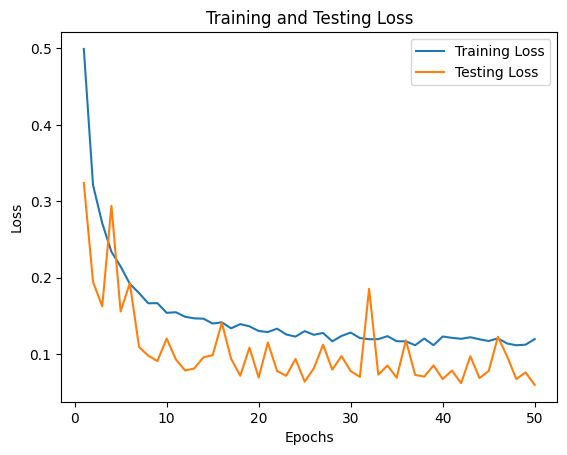

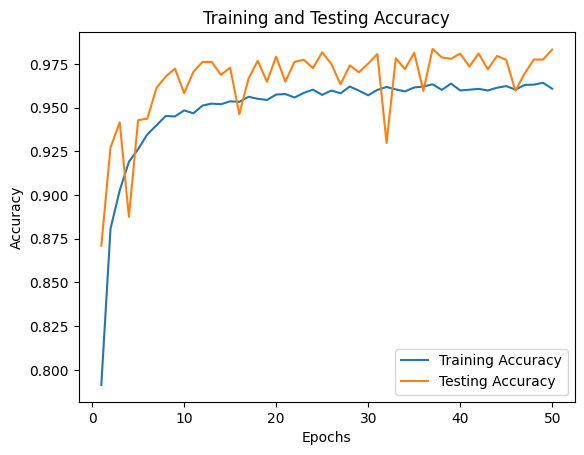

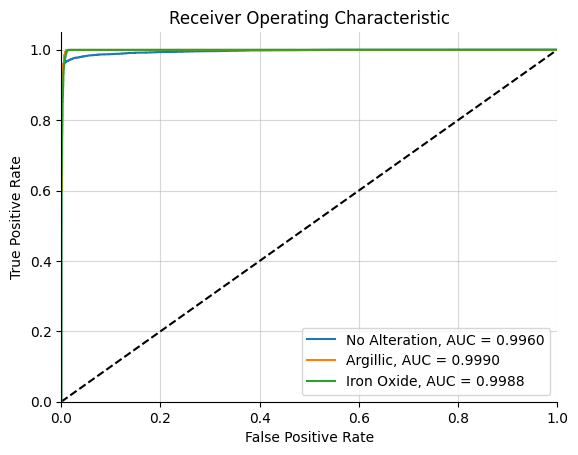

ROC AUC score: 0.9978944874749774


In [13]:
best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 5
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Iron Oxide', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

    for j in range(cv):
        train_x, train_y, test_x, test_y = train_test_split(features, labels)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Iron Oxide']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

91947/91947 [==============================] - 495s 5ms/step


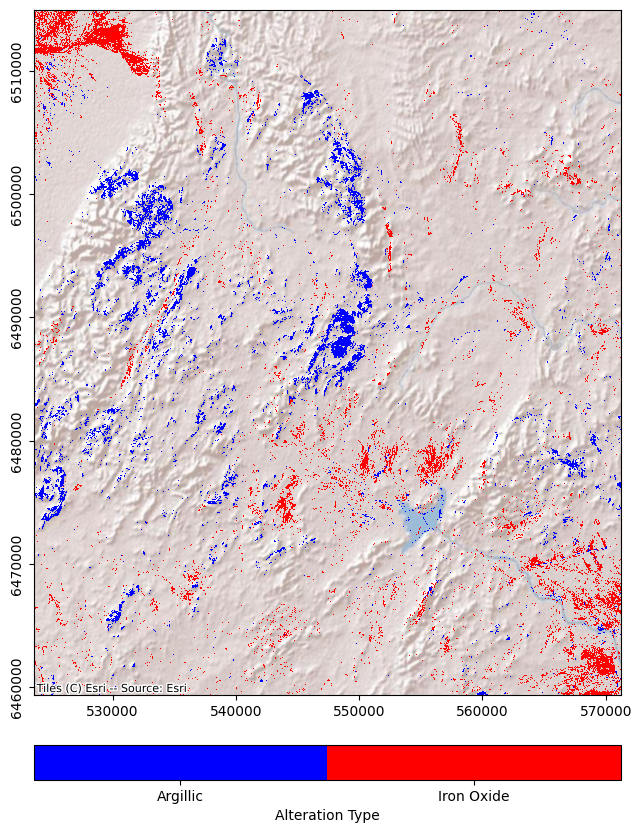

In [14]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
arrPred = arrPred.astype(float)
arrPred_fuzzy = np.zeros(arrPred.shape)

for i in range(arrPred.shape[0]):
    bandMin = arrPred[i, :, :].min()
    bandMax = arrPred[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[1]):
        for k in range(arrPred.shape[2]):
            arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# generate image chips from the array
pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

# predict and export the probability raster
pred = best_model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat8_PCA_CNN_AlterationMap_ks_7.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')